In [1]:
# Step 1: Import Libraries
import torch
from fastai.vision.all import *
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set path to your dataset
path = Path('/content/drive/MyDrive/Final year project documents/Blood cancer cell images')

# Label function
def label_func(x): return x.parent.name

# Augmentation and transformations
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y=label_func,
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(mult=2)  # Apply augmentations
)

# Create DataLoaders
dls = dblock.dataloaders(path, bs=32)

Mounted at /content/drive


In [2]:
# Step 2: Load Pre-trained Model
learn = cnn_learner(dls, resnet34, metrics=[accuracy, error_rate])

# Fine-tune the model with one cycle
learn.fine_tune(4)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 90.9MB/s]


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.578246,0.232414,0.912442,0.087558,35:43


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.290482,0.136083,0.960829,0.039171,52:01
1,0.196983,0.095712,0.968510,0.031490,52:35
2,0.136366,0.029223,0.992320,0.007680,51:54


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.290482,0.136083,0.960829,0.039171,52:01
1,0.196983,0.095712,0.968510,0.031490,52:35
2,0.136366,0.029223,0.992320,0.007680,51:54
3,0.079634,0.027556,0.990015,0.009985,51:57


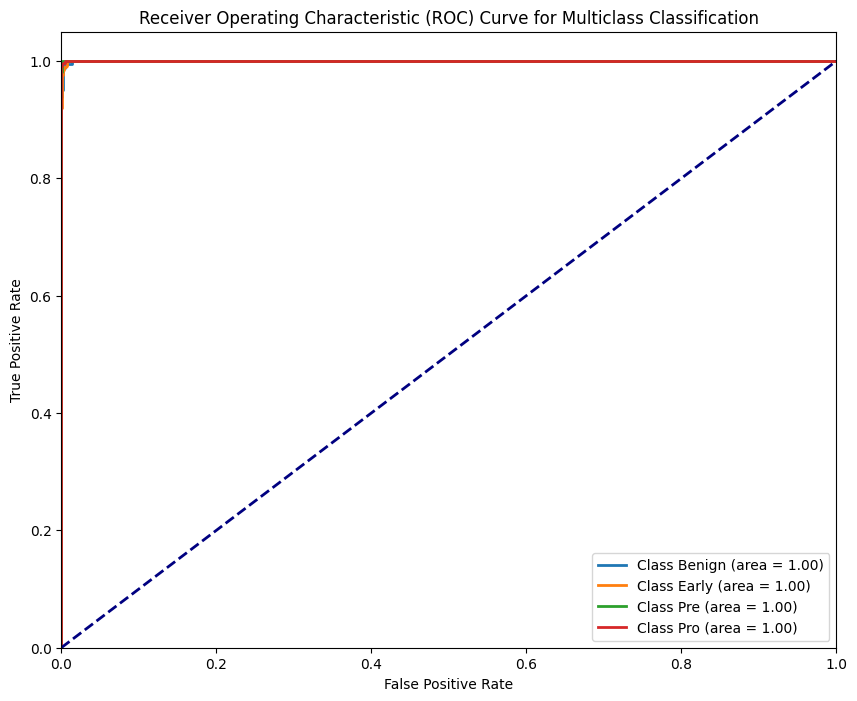

In [5]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Get the predictions and true labels
preds, targs = learn.get_preds()

# Binarize the labels for ROC curve (one-hot encoding)
true_labels = label_binarize(targs, classes=range(len(dls.vocab)))

# Get predicted probabilities for each class
pred_probs = preds.numpy()

# Plot ROC curve for each class
n_classes = len(dls.vocab)
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for all classes
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {dls.vocab[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

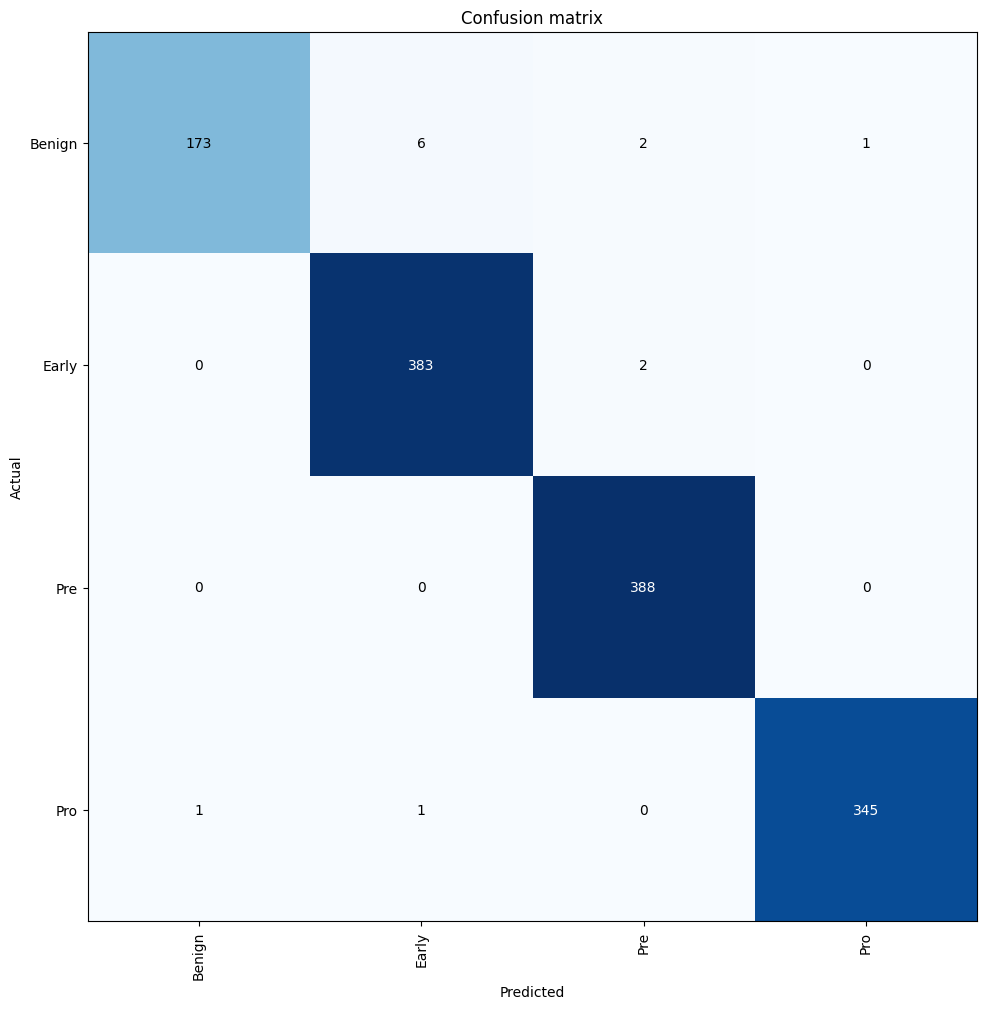

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10, 10))

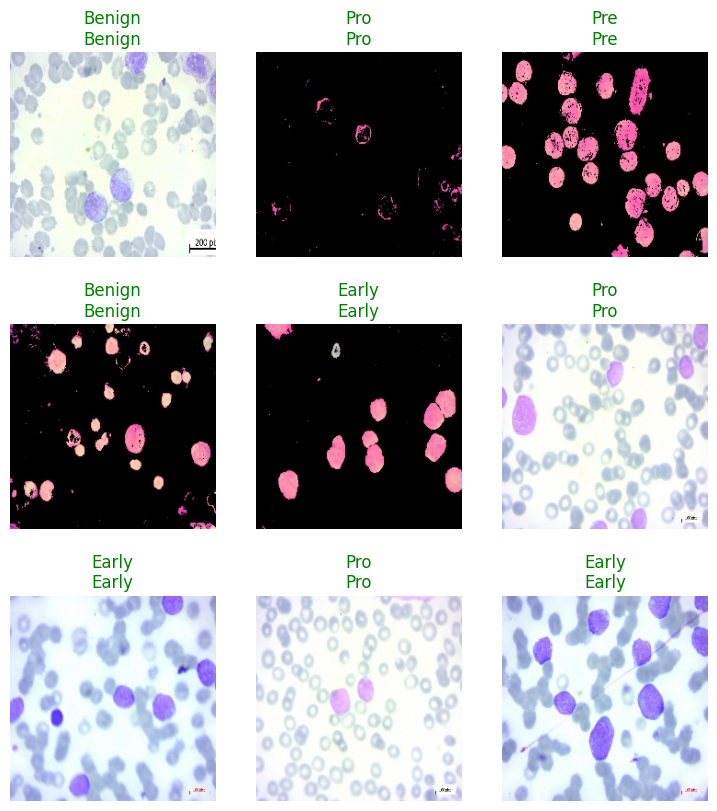

In [19]:
learn.show_results(figsize=(9, 10))

In [6]:
# Step 4: Track Advanced Metrics
from sklearn.metrics import classification_report

# Get predictions and true labels
preds, targs = learn.get_preds()

# Convert predictions and targets into a list
pred_labels = preds.argmax(dim=1)
report = classification_report(targs, pred_labels, target_names=dls.vocab)
print(report)

              precision    recall  f1-score   support

      Benign       0.99      0.95      0.97       182
       Early       0.98      0.99      0.99       385
         Pre       0.99      1.00      0.99       388
         Pro       1.00      0.99      1.00       347

    accuracy                           0.99      1302
   macro avg       0.99      0.98      0.99      1302
weighted avg       0.99      0.99      0.99      1302



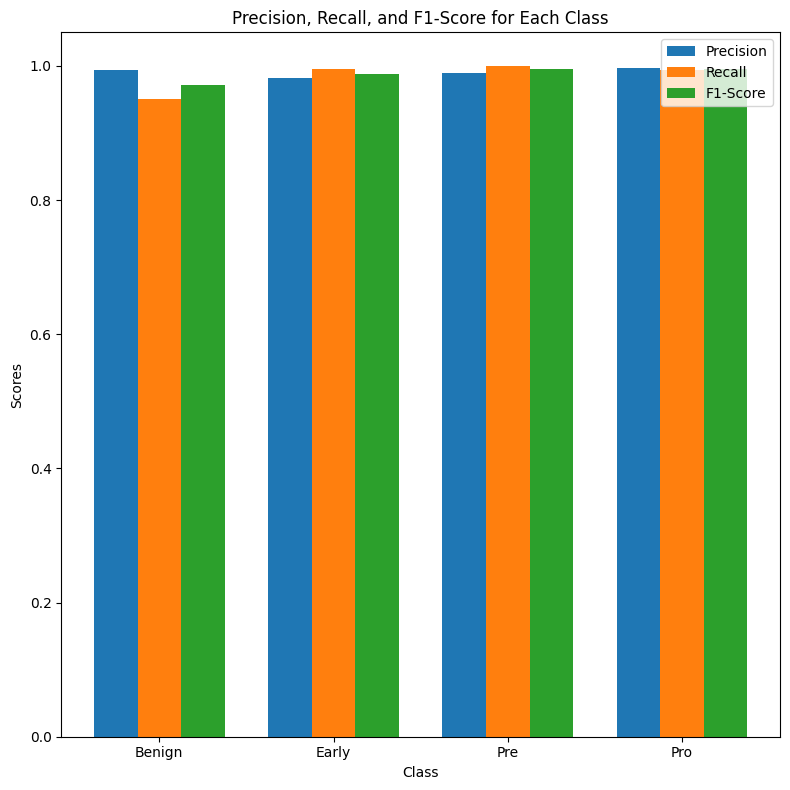

In [21]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Get predictions and true labels
preds, targs = learn.get_preds()

# Convert predictions to numpy array
pred_labels = preds.argmax(dim=1)

# Get the classification report (precision, recall, f1)
report = classification_report(targs, pred_labels, target_names=dls.vocab, output_dict=True)

# Extract precision, recall, and f1-score for each class
precision = [report[class_name]['precision'] for class_name in dls.vocab]
recall = [report[class_name]['recall'] for class_name in dls.vocab]
f1_score = [report[class_name]['f1-score'] for class_name in dls.vocab]

# Set up the bar plot
labels = dls.vocab
x = np.arange(len(labels))
width = 0.25  # Width of the bars

fig, ax = plt.subplots(figsize=(8, 8))

# Plot bars for precision, recall, and f1-score
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1-Score')

# Add labels and title
ax.set_xlabel('Class')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-Score for Each Class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()


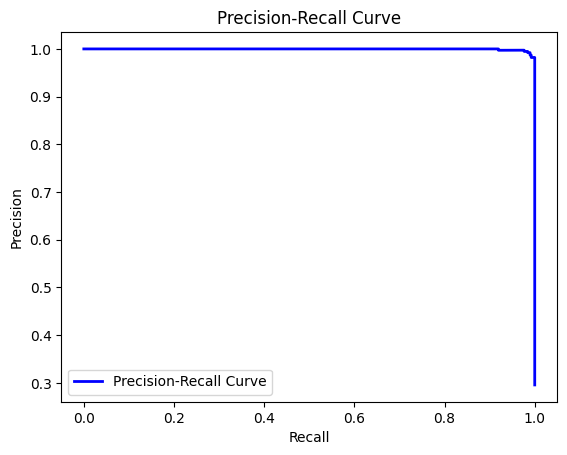

In [22]:
from sklearn.metrics import precision_recall_curve

# Plot Precision-Recall curve for a particular class (e.g., Class 1)
precision, recall, _ = precision_recall_curve(true_labels[:, 1], pred_probs[:, 1])
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

In [13]:
# Step 5: Save the Model
learn.save('best_leukemia_model')

Path('models/best_leukemia_model.pth')